# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# Functions

In [2]:
def set_cutoff(event_date, df):
    df_cutoff = df.copy()
    df_cutoff.date = pd.to_datetime(df_cutoff.date)
    df_cutoff['cutoff'] = df_cutoff['date'].apply(lambda x: 1 if x > pd.Timestamp(event_date) else 0)
    df_cutoff['days'] =  ((df_cutoff['date'] - pd.Timestamp(event_date)) / 86400000000000).astype(int)
    return df_cutoff

def set_date_range(start, end, df):
    df_date = df.copy()
    df_date.date = pd.to_datetime(df_date.date)
    df_date = df_date[(df_date.date > pd.Timestamp(start)) & (df_date.date < pd.Timestamp(end))]
    return df_date

def get_p(feature, df):
    print(smf.ols(f"{feature}~days*cutoff", df).fit().pvalues)

def get_summary(feature, df):
    print(smf.ols(f"{feature}~days*cutoff", df).fit().summary())

def get_poly(df):
    df2 = df.copy()
    df2 = df2.iloc[:,1:] ** 2
    df2.rename(columns={'hospitalisations': 'hospitalisations2',
            'cases': 'cases2',
            'deaths': 'deaths2',
            'cutoff': 'cutoff2',
            'days': 'days2',
            'cases_pred': 'cases_pred2',
            'deaths_pred': 'deaths_pred2',
            'hospitalisations_pred': 'hospitalisations_pred2' 
    }, inplace=True)
    df2 = pd.concat((df, df2), axis = 1)
    return df2    

def get_prediction_poly(feature, df):
    df2 = get_poly(df)
    model = smf.ols(f"{feature}~days*cutoff+days2*cutoff2", df2).fit()
    return model.fittedvalues

def get_predictions_poly(df):
    df_pred = df.copy()
    df_pred['cases_pred'] = get_prediction_poly('cases', df_pred)
    df_pred['deaths_pred'] = get_prediction_poly('deaths', df_pred)
    df_pred['hospitalisations_pred'] = get_prediction_poly('hospitalisations', df_pred)
    return df_pred

def get_prediction(feature, df):
    model = smf.ols(f"{feature}~days*cutoff", df).fit()
    return model.fittedvalues

def get_predictions(df):
    df_pred = df.copy()
    df_pred['cases_pred'] = get_prediction('cases', df_pred)
    df_pred['deaths_pred'] = get_prediction('deaths', df_pred)
    df_pred['hospitalisations_pred'] = get_prediction('hospitalisations', df_pred)

    return df_pred
  
def get_ax(ax, color, feature, df, alpha=0.1):
    ax.scatter(df.date, df[feature], color=color, alpha=alpha)
    ax.plot(df.date[df.days <= 0], df[f"{feature}_pred"][df.days <= 0], color=color)
    ax.plot(df.date[df.days > 0], df[f"{feature}_pred"][df.days > 0], color=color)
    ax.set_ylabel(feature.capitalize())
    ax.set_xticks(df.date)
    ax.set_xticklabels(df.date.dt.strftime("%d %b"), rotation = 60)
    ax.locator_params(axis='x', nbins=15)
    return ax

def show_chart(df, title):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    ax[0] = get_ax(ax[0], 'r', 'cases', df)
    ax[1] = get_ax(ax[1], 'g', 'hospitalisations', df)
    ax[2] = get_ax(ax[2], 'b', 'deaths', df)

    fig.suptitle(title)
    plt.show()

# Load Data

In [4]:
cases_df = pd.read_csv('../data/cases.csv')
death_df = pd.read_csv('../data/death.csv')
hospitalisation_df = pd.read_csv('../data/hospitalisations.csv')
df = hospitalisation_df.merge(cases_df, on='date', how='left')
df = df.merge(death_df, on='date', how='left')

#NOTE: Here the data is partially fake to match the start of the data. There is more 0s at the head of the DF.
df = df.fillna(0)

# Events 

The following figures each respectively display the discontinuity in cases, deaths, and hospitalizations due to COVID in Quebec concerning specific events: the first lockdown, schools reopening, and a subsequent lockdown. While the specific data differs, cases, hospitalizations, and deaths all follow a similar trend. Our discussion will focus on the first graph of each figure, depicting new cases per day.

## First Lockdown

At first glance, the model for the first lockdown suggests that the cutoff point (lockdown 20/03/2020) has a positive effect on new cases per day. With a significant days:cutoff coefficient of 12.8961, we observe an increase in cases after the lockdown is instated. However, examining other models indicates that this lockdown likely had a slowing effect on the growth of cases. This initial plot includes data from the start of the pandemic in Canada, even when there are zero cases per day.
Despite the lockdown being issued, it wasn't until several positive cases emerged, indicating that the virus was already spreading. This explains the increase in cases despite the lockdown procedure. Starting from zero, even a small jump in cases yields the positive coefficient observed in the model. To understand the significance of this lockdown, similar plots at other points in time in Quebec need examination.

### P-Values
- Days, days2 and intercept have high p-value. For the intercept it could be because there is 2 extremely different intercept here. One near 0 and the other one probably in the -1000 or more.
- Here we use 1 polynomial and we extend the chart so that the post lockdown show the first wave of the pandemie till it calm backdown.
- Cutoff parameter is at 1 after march 20, 2020 and that way all the coeficient cutoff, days:cutoff, cutoff2 and days2:cutoff2 have an effect to fit this rise and fall of case, hospitalisations and deaths.

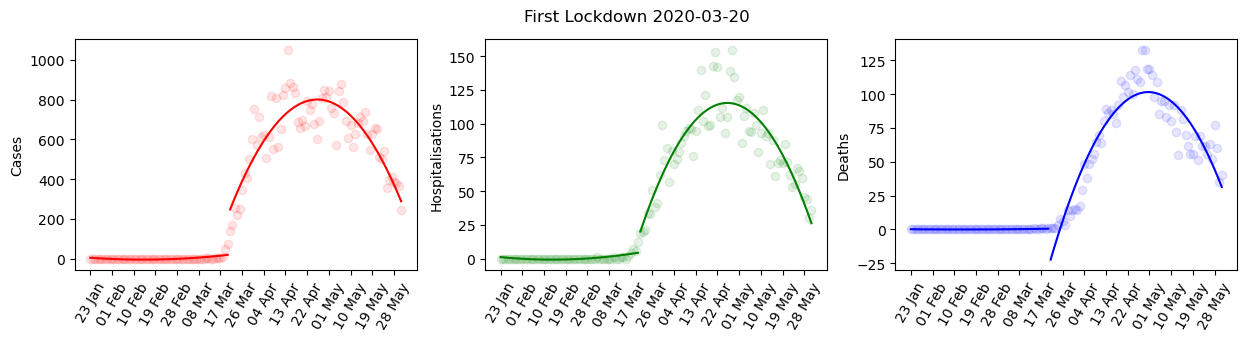

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        20.0324     28.771      0.696      0.488     -36.913      76.978
days              1.3557      2.334      0.581      0.562      -3.264       5.975
cutoff           98.5284     19.892      4.953      0.000      59.156     137.901
days:cutoff      30.0145      2.909     10.316      0.000      24.256      35.773
days2             0.0194      0.040      0.489      0.625      -0.059       0.098
cutoff2          98.5284     19.892      4.953      0.000      59.156     137.901
days2:cutoff2    -0.4412      0.046     -9.626      0.000      -0.532      -0.350
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3507      4.334      1.004      0.317      -4.227      12.929
days            

In [5]:
df_first = set_cutoff('2020-03-20', df)
df_first = set_date_range('2020-01-01', '2020-06-01', df_first)
df_first = get_predictions_poly(df_first)
show_chart(df_first, 'First Lockdown 2020-03-20')
df_first2 = get_poly(df_first)
print(smf.ols("cases~days*cutoff+days2*cutoff2", df_first2).fit().summary().tables[1])
print(smf.ols("hospitalisations~days*cutoff+days2*cutoff2", df_first2).fit().summary().tables[1])
print(smf.ols("deaths~days*cutoff+days2*cutoff2", df_first2).fit().summary().tables[1])

## School Openning

The second model closely resembles the first. A small number of relatively stable cases per day, followed by an upward trend after the cutoff, suggests that reopening schools in Quebec (31/8/2020) had a positive effect on new cases per day. The cutoff coefficient (12.6973) is extremely close to that of the first model. The difference lies in the number of cases, with the reopening of schools contributing to the highest number of new cases observed throughout the entire pandemic.

Compared to the previous graph, cases rise after the lockdown due to the virus being newly introduced to Quebec but then remain stable or decrease over time while the lockdown persists. This suggests the effectiveness of the lockdown in slowing the virus, confirmed by the jump in cases as some restrictions are lifted. Without the implementation of a lockdown, new cases likely would have increased much more dramatically in a short time, as seen in the contrast between the first and second figures. This would also apply to hospitalizations, following a similar trend, and would have been catastrophic as many hospitals were already over capacity.

### P-Values
- Again Days doesn't show really good sign of accuracy but the cutoff has well in this case. There is a hump around october that we average here so it could be that.
- No polynomial for this regression. The graph goes to the top of this wave. With 1 polynomial the p-values were getting very high value and over fitting
- Interesting to see that the intercept has better p-value here and both intercept are closer in value since the slope change is less extreme.

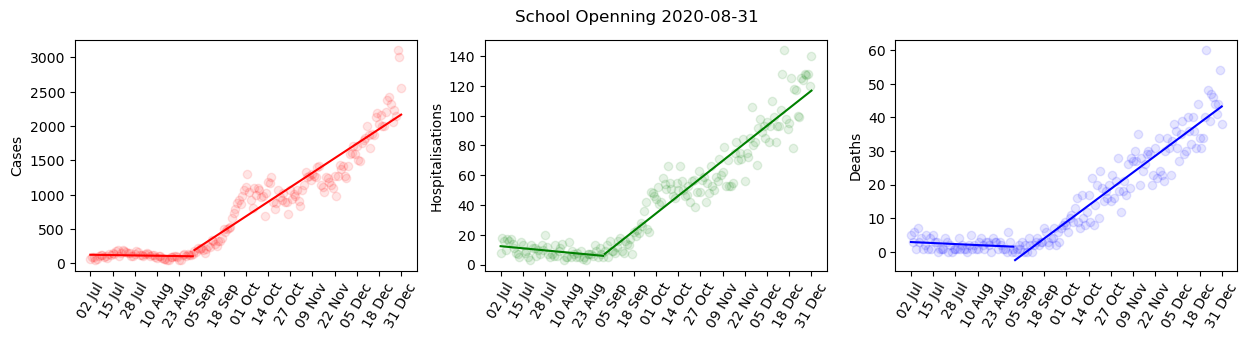

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     103.0312     50.274      2.049      0.042       3.825     202.238
days           -0.3689      1.445     -0.255      0.799      -3.221       2.483
cutoff         74.4055     61.957      1.201      0.231     -47.854     196.665
days:cutoff    16.6675      1.533     10.873      0.000      13.643      19.693
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.8673      2.480      2.366      0.019       0.974      10.760
days           -0.1082      0.071     -1.519      0.131      -0.249       0.032
cutoff          0.4107      3.056      0.134      0.893      -5.619       6.441
days:cutoff     1.0142      0.076     13.414      0.000       0.865       1.163
                  coef    std err       

In [6]:
df_school = set_cutoff('2020-08-31', df)
df_school = set_date_range('2020-07-01', '2021-01-01', df_school)
df_school = get_predictions(df_school)
show_chart(df_school, 'School Openning 2020-08-31')
print(smf.ols("cases~days*cutoff", df_school).fit().summary().tables[1])
print(smf.ols("hospitalisations~days*cutoff", df_school).fit().summary().tables[1])
print(smf.ols("deaths~days*cutoff", df_school).fit().summary().tables[1])

## Final Lockdown

The last plot illustrates the effects of the second lockdown (25/12/2020) and shows a negative coefficient after the cutoff (-56.8661). This implies that implementing this lockdown reduced new cases, the spread of the virus, as well as deaths and hospitalizations due to COVID in Quebec. In the previous two graphs, spikes in the number of cases occurred, likely due to 1: the new virus being introduced to a previously unaffected population despite lockdown procedures, and 2: the cessation of the lockdown and reintroduction of busy public spaces, respectively.

At this point in the pandemic, a large portion of the population had been infected. Combined with a second lockdown, this significantly slowed the spread and opportunity for new cases. Considering all three graphs together is important, as focusing only on the first might lead to the assumption, based on the summary alone, that the lockdown increased the number of cases across the province. Instead, it likely helped prevent hospitalization rates from rising out of control. Examining data from all three points in time provides valuable insights into why these numbers are observed and what can be inferred from them, including the lockdown's effectiveness at different times throughout the pandemic.

### P-Values
- Days and days:cutoff are not good. I suppect that by offsetting the cutoff date by couple of days we could have better fit.
- Cutoff is particuly accurate on this data.
- Polynomial help in this case. We were able to show longer timeframe without losing the fit while keeping fairly good p-value.

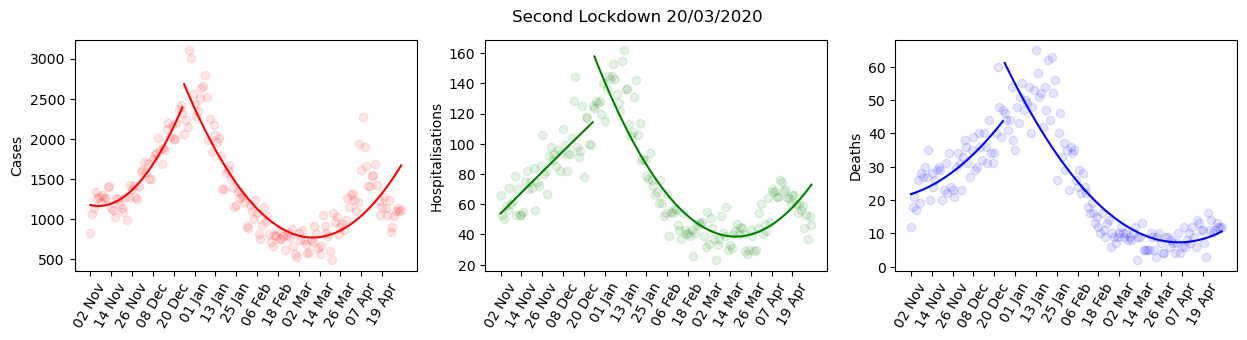

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2392.7556    107.574     22.243      0.000    2180.438    2605.073
days             50.6679      9.386      5.398      0.000      32.143      69.193
cutoff          170.1708     65.347      2.604      0.010      41.195     299.146
days:cutoff    -102.8275      9.766    -10.529      0.000    -122.103     -83.552
days2             0.5229      0.171      3.053      0.003       0.185       0.861
cutoff2         170.1708     65.347      2.604      0.010      41.195     299.146
days2:cutoff2    -0.1759      0.173     -1.020      0.309      -0.516       0.165
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       114.2241      5.779     19.764      0.000     102.817     125.631
days            

In [7]:
df_christmas = set_cutoff('2020-12-25', df)
df_christmas = set_date_range('2020-11-01', '2021-05-01', df_christmas)
df_christmas = get_predictions_poly(df_christmas)
show_chart(df_christmas, 'Second Lockdown 20/03/2020')
df_christmas2 = get_poly(df_christmas)
print(smf.ols("cases~days*cutoff+days2*cutoff2", df_christmas2).fit().summary().tables[1])
print(smf.ols("hospitalisations~days*cutoff+days2*cutoff2", df_christmas2).fit().summary().tables[1])
print(smf.ols("deaths~days*cutoff+days2*cutoff2", df_christmas2).fit().summary().tables[1])